In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import dependencies and data

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import HuberRegressor, LinearRegression, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Acquiring the data

In [3]:
'''
Data paths for kaggle online working

df = pd.read_csv(r'/kaggle/input/titanic/train.csv')
df_test = pd.read_csv(r'/kaggle/input/titanic/test.csv')
df_gender = pd.read_csv(r'/kaggle/input/titanic/gender_submission.csv')
'''
# Data paths for desktop offline working

df = pd.read_csv(r'./input/train.csv')
df_test = pd.read_csv(r'./input/test.csv')
df_gender = pd.read_csv(r'./input/gender_submission.csv')

# Exploring the data

First we explore the features available in the data.

In [4]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Second, we preview the data in order to identify further information regarding the features.

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can find 5 categorical features (Survived, Pclass, Sex, Cabin and Embarked) and 4 continuous fetures (Age, SibSp, Parch and Fare).

Ticket and Cabin are mixed features, harder to deal with. 

Name feature won't be taken into account as is a proxy for PassengerId.

We can find the description for the variables here: https://www.kaggle.com/c/titanic/data

### Distribution os feature values 

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Total samples are 891 for the training test.
- Survived is a category with 0 or 1 values and present a 38% survival rate.
- Most passengers (> 75%) did not travel with parents or children.
- Passengers on the titanic were mostly young since q75 is at age 38 and max age is 80.

In [7]:
df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Rothes, the Countess. of (Lucy Noel Martha Dye...",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


- Sex values only have 2 possible values.
- Ticket and Cabin values present a high rate of duplicates
- Embarked present 3 values with the top value being S (Southampton, the first of the 3 ports before the accident took place)

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [9]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [10]:
print(df.isnull().sum())
print('/'*50)
print(df_test.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
//////////////////////////////////////////////////
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Correlation of features. 

We will check survival correlation between the categorical features.

In [11]:
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Since the Cabin value may be biased towards the declarations took after the accident we will transform the values to a binary ditribution and check if this assumption could be right.

In [14]:
df['Cabin'] = df['Cabin'].notnull().astype(int)
df[['Cabin', 'Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Cabin,Survived
1,1,0.666667
0,0,0.299854


In [15]:
df_test['Cabin'] = df_test['Cabin'].notnull().astype(int)

We can see a clear correlation between survival and having the cabin value available and thus we can assume there is a bias in the feature values.

## Visualizations

We can look at the distribution of survivors by age.

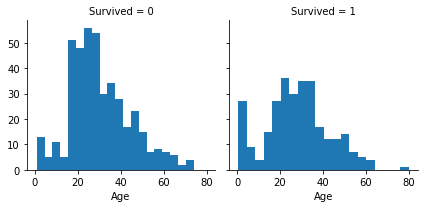

In [16]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20);

And categorize it by class.

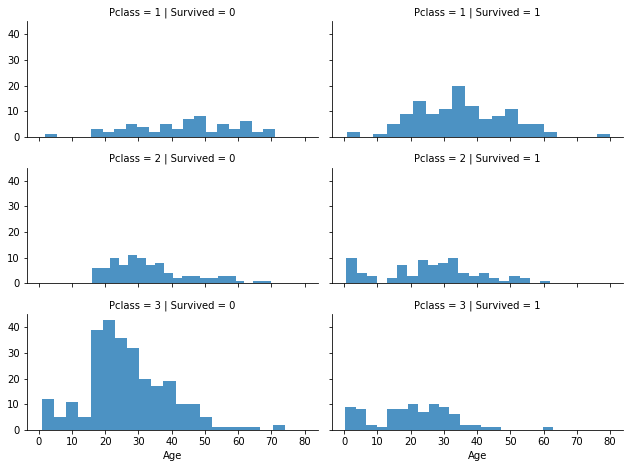

In [17]:
grid = sns.FacetGrid(df, col='Survived', row='Pclass', height=2.2, aspect=2)
grid.map(plt.hist, 'Age', alpha=.8, bins=20)
grid.add_legend()
plt.show()

We can also look at the port of embarking and figure out if it had a significant impact on survival rate.

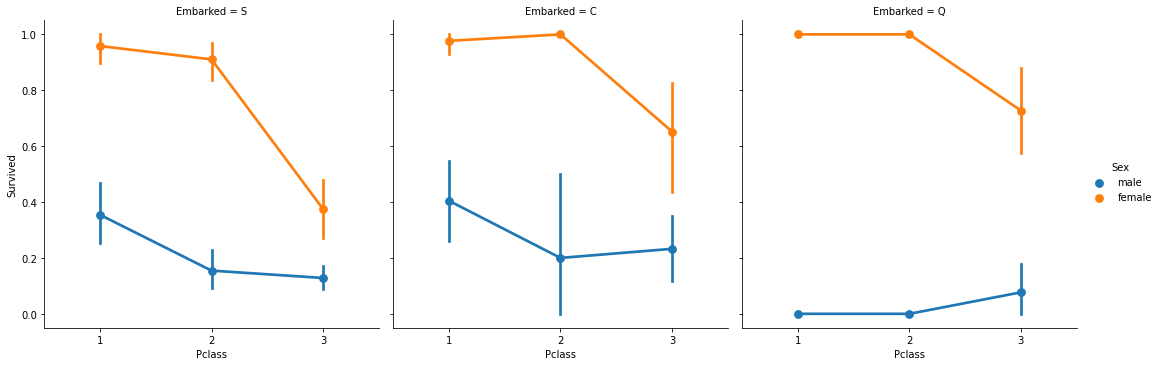

In [18]:
sns.catplot(x='Pclass',col='Embarked',y='Survived',hue='Sex',data=df,kind='point')
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


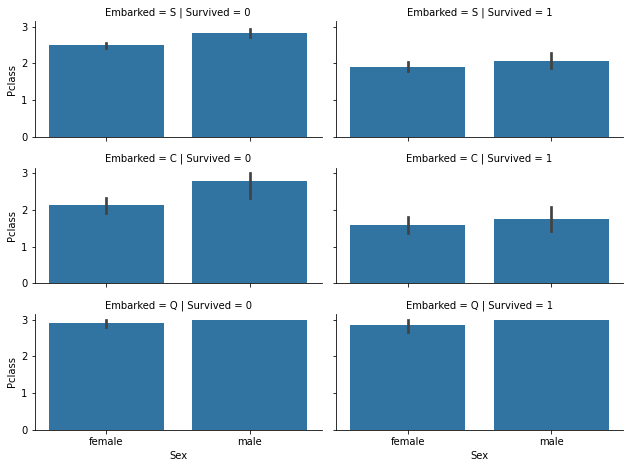

In [19]:
grid = sns.FacetGrid(df, col='Survived', row='Embarked', height=2.2, aspect=2)
grid.map(sns.barplot, 'Sex', 'Pclass')
grid.add_legend()
plt.show()

We can see that males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. This could mean that emarking port could have some relevance for certain groups.

Let's convert them into dummy variables so we can use afterwards.

Most common value foor Embarked is S so let's fill the two missing values with that.

In [20]:
df['Embarked'] = df['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

In [21]:
df = df.merge(pd.get_dummies(df['Embarked']), left_index=True, right_index=True)
df_test = df_test.merge(pd.get_dummies(df_test['Embarked']), left_index=True, right_index=True)

# Dataframe Transformations

In [22]:
# model_col = ['Survived', 'Pclass', 'Age_new', 'SibSp', 'Parch', 'Sex_new', 'Cabin_new']

## Transformations to training and testing dataset

In this part we will transform training and testing datasets into workable datasets.

First we will drop the features we didn't see fit for the problem.

In [23]:
df = df.drop(['Ticket'], axis=1)
df_test = df_test.drop(['Ticket'], axis=1)

After that we will take a look to the Name feature.

In [24]:
df['Name'].tail()

886                       Montvila, Rev. Juozas
887                Graham, Miss. Margaret Edith
888    Johnston, Miss. Catherine Helen "Carrie"
889                       Behr, Mr. Karl Howell
890                         Dooley, Mr. Patrick
Name: Name, dtype: object

After reviewing the data we can see that the passengers had a tittle attaached to their names.

Let's find out what are the most common titles by extracting them from the names.

In [25]:
# every title is before a "." and after a *blank space* so we will look there

for dataset in [df, df_test]:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

print(df['Title'].value_counts().sum())
pd.crosstab(df['Title'], df['Sex'])

891


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


According to the list we can assume 2 things:

- Titles in names were universal.
- Some passengers had titles beyond Mrs and Mr which can indicate a higher status in society.

We can change rare titles to a new variable "HighStatus" and see the correlation with survival.
We can also change the rest of the titles and look for further correlations.

In [26]:
for dataset in [df, df_test]:
    dataset['HighStatus'] = dataset['Title'].isin(
        ['Lady', 'Countess','Capt', 'Col',	'Don', 'Dr', 'Major', 'Master', 'Rev', 'Sir', 'Jonkheer', 'Dona']
        ).astype(int)

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [27]:
df[['HighStatus', 'Survived']].groupby(['HighStatus'], as_index=False).mean()

,HighStatus,Survived
0,0,0.375604
1,1,0.492063


Half of the people with a social title survived so we can assume this is a relevant feature.

Now we transform the Sex feature into a binary feature.

In [28]:
for dataset in [df, df_test]:
    dataset['Sex'] = (dataset['Sex'].values == 'female').astype(int)

One-hot encode of relevant variables.

In [29]:
for dataset in [df, df_test]:
    # define values
    data = dataset['Pclass']
    values = np.array(data)
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    dataset[['Pclass1', 'Pclass2', 'Pclass3']] = onehot_encoded.astype(int)
    #df.drop('Pclass', axis=1, inplace=True)

## Completing the Age feature

Age is the only feature that has a relevant amount of NaN values.

The options are:

    1. Generate random numbers to fill the NaN values.
    2. Guess the age based on other features.

The best result will come, of course, doing the second option although it could be challenging.

Lets try to fill the values with predictions drawn of a model.

First we have to select the data we are using for th eprediction, we do this based on the correlation matrix. 

In [30]:
# Ahora mismo da igual que modelo utilicemos para la prediccion, todos dan un rmse de alrededor de 12 asi que estoy 
# valorando dejar el kn reg como modelo preferido pero dal la explicacion sobre como todos son bastante similares y que predecir esta feature es bastante complicado

cols = ['Pclass1', 'Pclass3', 'Age', 'SibSp', 'Parch', 'Cabin', 'HighStatus']

# setting up the train and test datasets
#train
age_train = df[df['Age'].notna()][cols]
age_train_x = age_train.drop('Age', axis=1)
age_train_y = age_train['Age']
#test
age_test = df_test[df_test['Age'].notna()][cols]
age_test_x =  age_test.drop('Age', axis=1)
age_test_y = age_test['Age']
#prediction
age_pred_train = df[df['Age'].isna()][cols].drop('Age', axis=1)
age_pred_test = df_test[df_test['Age'].isna()][cols].drop('Age', axis=1)

List of regression models to test.

In [31]:
# setting up pipelines
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledHR', Pipeline([('Scaler', StandardScaler()),('HR', HuberRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', LinearSVR())])))

# testing models
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, age_train_x, age_train_y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = f'{name} : {cv_results.mean()} ({cv_results.std()})'
    print(msg)

ScaledLR : -162.897313253756 (20.960993844555798)
ScaledLASSO : -167.03322917696676 (20.80106768010238)
ScaledEN : -168.72977473088034 (21.159316523704668)
ScaledKNN : -171.5877427443662 (11.553227342620756)
ScaledCART : -152.35292093968678 (15.288202131923079)
ScaledGBM : -142.02233810348284 (19.48924621195293)
ScaledHR : -164.85555571120835 (25.727276547235835)
ScaledSVR : -170.63987132916395 (29.94962198991397)


We can conclude KNN is the best prediction model for Age filling although it is not very accurate.

Nevertheless, we will use it since it is better than filling with the mean.

Next we will search for the best hiperparameters for KNN:

RMSE value for k=  1 is: 12.822267317312741
RMSE value for k=  2 is: 12.77135498162973
RMSE value for k=  3 is: 12.487625328889292
RMSE value for k=  4 is: 13.333525397464816
RMSE value for k=  5 is: 12.498634328954585
RMSE value for k=  6 is: 12.23500566612009
RMSE value for k=  7 is: 11.918960929096771
RMSE value for k=  8 is: 11.758657827437252
RMSE value for k=  9 is: 11.90568471405115
RMSE value for k=  10 is: 11.887856777711853
RMSE value for k=  11 is: 11.958141220719405
RMSE value for k=  12 is: 11.992007938137316
RMSE value for k=  13 is: 11.982292176938769
RMSE value for k=  14 is: 12.033931566127425
RMSE value for k=  15 is: 11.960896870472418
RMSE value for k=  16 is: 11.985905200889315
RMSE value for k=  17 is: 11.936601645230331
RMSE value for k=  18 is: 12.053047379938983
RMSE value for k=  19 is: 12.011667895439125
RMSE value for k=  20 is: 12.081534858233162


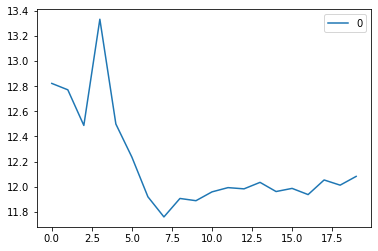

In [32]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
%matplotlib inline
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, weights='distance')

    model.fit(age_train_x, age_train_y)  #fit the model
    pred = model.predict(age_test_x) #make prediction on test set
    error = np.sqrt(mean_squared_error(age_test_y, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot();

From the results we can determine that `K=8` is the best value for the parameter. 

In [33]:
knn = KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
knn.fit(age_train_x, age_train_y)

prediction_train = knn.predict(age_pred_train)
prediction_test = knn.predict(age_pred_test)

Next we replace the NaN values with the predictions.

In [34]:
df.loc[df['Age'].isna(), 'Age'] = prediction_train
df_test.loc[df_test['Age'].isna(), 'Age'] = prediction_test

In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int32  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    int32  
 10  Embarked     891 non-null    object 
 11  C            891 non-null    uint8  
 12  Q            891 non-null    uint8  
 13  S            891 non-null    uint8  
 14  Title        891 non-null    object 
 15  HighStatus   891 non-null    int32  
 16  Pclass1      891 non-null    int64  
 17  Pclass2      891 non-null    int64  
 18  Pclass3      891 non-null    int64  
dtypes: float

In [36]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int32  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         417 non-null    float64
 8   Cabin        418 non-null    int32  
 9   Embarked     418 non-null    object 
 10  C            418 non-null    uint8  
 11  Q            418 non-null    uint8  
 12  S            418 non-null    uint8  
 13  Title        418 non-null    object 
 14  HighStatus   418 non-null    int32  
 15  Pclass1      418 non-null    int64  
 16  Pclass2      418 non-null    int64  
 17  Pclass3      418 non-null    int64  
dtypes: float64(2), int32(3), int64(7), object(3), uint

In [37]:
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

# *CURRENTLY WORKING HERE*

In [49]:
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin', 'Embarked', 'C', 'Q', 'S', 'Title', 'HighStatus', 'Pclass1',
       'Pclass2', 'Pclass3'],
      dtype='object')

In [48]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,C,Q,S,Title,HighStatus,Pclass1,Pclass2,Pclass3
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,S,0,0,1,Mr,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,C,1,0,0,Mrs,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,S,0,0,1,Miss,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,1,S,0,0,1,Mrs,0,1,0,0
4,5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,S,0,0,1,Mr,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",0,27.0,0,0,13.0000,0,S,0,0,1,Rev,1,0,1,0
887,888,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,30.0000,1,S,0,0,1,Miss,0,1,0,0
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,26.0,1,2,23.4500,0,S,0,0,1,Miss,0,0,0,1
889,890,1,"Behr, Mr. Karl Howell",0,26.0,0,0,30.0000,1,C,1,0,0,Mr,0,1,0,0


In [86]:
model_cols = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'C', 'Q', 'S', 'HighStatus', 'Pclass1', 'Pclass2', 'Pclass3', 'Survived']
X = df[model_cols].drop('Survived', axis=1)
y = df['Survived']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=, random_state=42)

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# setting up pipelines
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledDTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier())])))
pipelines.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier())])))
pipelines.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()),('SVC', SVC())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
pipelines.append(('ScaledGBC', Pipeline([('Scaler', StandardScaler()),('GBC', GradientBoostingClassifier(n_estimators=20, learning_rate=0.075, max_features=2, max_depth=2, random_state=0))])))

# testing models
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = f'{name} : {cv_results.mean()} ({cv_results.std()})'
    print(msg)

ScaledLR : -0.18179775280898874 (0.02862766122121385)
ScaledDTC : -0.2143196004993758 (0.026817342483966253)
ScaledRFC : -0.18848938826466916 (0.039742822335936324)
ScaledSVC : -0.16496878901373285 (0.03652397894573245)
ScaledKNN : -0.19525593008739076 (0.024945057386287207)
ScaledGBC : -0.2457178526841448 (0.0425175955994466)


With these results let's look at the top 3 models.
We will tune up their hyperparameters and compare them again to determine the best results.

### Logistic Regression

In [68]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#sns.lineplot(zip(means, stds, params))

Best: 0.818161 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816288 (0.043922) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.815539 (0.042681) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816288 (0.043922) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.815539 (0.043559) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.817412 (0.043382) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.815539 (0.043559) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.818161 (0.041339) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.817786 (0.041775) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.818161 (0.041339) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.817037 (0.043607) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.816658 (0.044878) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816284 (0.046004) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.746737 (0.034656) wit

### Random Forest Classifier

In [70]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.818568 using {'max_features': 'sqrt', 'n_estimators': 10}
0.818568 (0.035593) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.812950 (0.036141) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.812210 (0.034895) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.814070 (0.034179) with: {'max_features': 'log2', 'n_estimators': 10}
0.807345 (0.038224) with: {'max_features': 'log2', 'n_estimators': 100}
0.812955 (0.036365) with: {'max_features': 'log2', 'n_estimators': 1000}


### Support Vector Classification

In [69]:
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.794228 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.704457 (0.024371) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.794228 (0.040523) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.558968 (0.033883) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.679018 (0.027927) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.727287 (0.035288) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.558964 (0.033943) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.652830 (0.022499) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.678269 (0.032916) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.565689 (0.036692) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.643475 (0.022879) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.675651 (0.034635) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.628161 (0.029575) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.635235 (0.020729) with: {'C': 0.01, 'gamma': 'scale', 

### K-Nearest Neighbors (KNN)

In [74]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.762451 using {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
0.688360 (0.047951) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.688360 (0.047951) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.723121 (0.042923) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.720886 (0.043613) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.710420 (0.035870) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.721648 (0.045692) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.715668 (0.036246) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.725027 (0.039312) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.704087 (0.045362) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.725031 (0.043534) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.705972

In [76]:
# setting up models
models = []
models.append(('LR',LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')))
models.append(('RFC', RandomForestClassifier(max_features= 'sqrt', n_estimators= 10)))
models.append(('SVC', SVC(C= 50, gamma= 'scale', kernel= 'rbf')))
models.append(('KNN',KNeighborsClassifier(metric= 'manhattan', n_neighbors= 15, weights= 'distance')))


# testing models
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = f'{name} : {cv_results.mean()} ({cv_results.std()})'
    print(msg)

LR : -0.18179775280898874 (0.02862766122121385)
RFC : -0.19745318352059923 (0.03198808851235474)
SVC : -0.20760299625468165 (0.0320534707703766)
KNN : -0.2468664169787765 (0.030927259691022745)


# MODEL

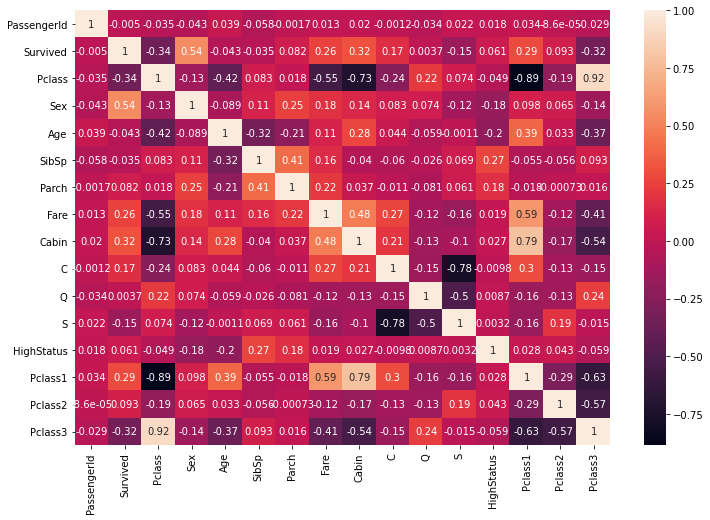

In [81]:
df_corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, annot=True)
plt.show()

In [82]:
model_cols = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'C', 'Q', 'S', 'HighStatus', 'Pclass1', 'Pclass2', 'Pclass3']

In [83]:
model = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')
model.fit(X, y)
X_test = df_test[model_cols]
y_test = model.predict(X_test)

In [84]:
final_df = pd.DataFrame()
final_df['PassengerId'] = df_test['PassengerId']
final_df['Survived'] = y_test
final_df.to_csv('titanic_results.csv',index=False)

In [85]:
pd.read_csv('titanic_results.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
